## Import Modules

In [161]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
import pickle

%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', -1)

np.random.seed(42)

## Load Clean DataFrame

In [162]:
with open('../Data/clean_df.pkl', 'rb') as f:
    df = pickle.load(f)

## Import Stopword List

In [163]:
with open('../Data/stop_word_list.pkl', 'rb') as f:
    stop_word_list = pickle.load(f)

## Set Up X and y Variables and Train Test Split

In [164]:
X = df['selftext'] + " " + df['title']
y = list(df['label'])

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

## TF-IDF Vectorizer with Multinomial Naive Bayes Model

TF–IDF (term frequency–inverse document frequency) considers the relative frequency or rareness of tokens in a document against their frequency in other documents. This encoding approach emphasizes terms that are very relevant to a specific instance.  It gives a value that is weighted relative to other documents, not absoulute like CountVectorizer does.

When using a  multinomial naive Bayes model it is assumed that your features are multinomially distributed.  This means that there is discrete data, which is the case in text classification using bags of words or TF-IDF approaches. Naive Bayes is a probabilistic classifier, 

Naive Bayes is a probabilistic classifier and therefore will calculate the probability of each category using Bayes theorem, and the category with the highest probability will be output.

In [166]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('model', MultinomialNB())])

In [167]:
params = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__max_df': [0.5, 0.6, 0.7],
    'tfidf__min_df': [2, 3, 4],
    'tfidf__ngram_range': [(1,1), (1,2)]
}

In [168]:
gs_multi = GridSearchCV(pipe, param_grid=params, cv=3)

In [169]:
gs_multi.fit(X_train, y_train);

In [170]:
gs_multi.score(X_train, y_train), gs_multi.score(X_test, y_test)

(0.9830234438156831, 0.9394673123486683)

In [171]:
gs_multi.best_params_ 

{'tfidf__max_df': 0.5,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

#### Plot the Top Five Gridsearch Parameter Combinations

I am going to plot the top five gridsearch parameter combinations.

In [172]:
selected__multi_params = pd.DataFrame(gs_multi.cv_results_).loc[:, ['params', 'mean_test_score']] \
.groupby('mean_test_score').count().sort_values('mean_test_score', ascending=False)
selected__multi_params.head()

,params
mean_test_score,
0.940178,3
0.939369,3
0.938561,3
0.937753,12
0.936944,9


There are a number of combinations that yield the same score, so I will pick one from each.

In [180]:
selected__multi_params = pd.DataFrame(gs_multi.cv_results_) \
.loc[:,['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

In [181]:
selected__multi_params = pd.DataFrame(gs_multi.cv_results_) \
.loc[[13, 51, 27, 29, 50],['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
selected__multi_params.head()

,params,mean_test_score
13,"{'tfidf__max_df': 0.5, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.940178
51,"{'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.939369
27,"{'tfidf__max_df': 0.6, 'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.938561
29,"{'tfidf__max_df': 0.6, 'tfidf__max_features': 2000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}",0.937753
50,"{'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}",0.936944


In [182]:
x = np.arange(selected__multi_params.shape[0])

In [183]:
y = selected__multi_params.mean_test_score.values

,params,mean_test_score
13,"{'tfidf__max_df': 0.5, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.940178
51,"{'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.939369
27,"{'tfidf__max_df': 0.6, 'tfidf__max_features': 2000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.938561
29,"{'tfidf__max_df': 0.6, 'tfidf__max_features': 2000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}",0.937753
50,"{'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 1)}",0.936944


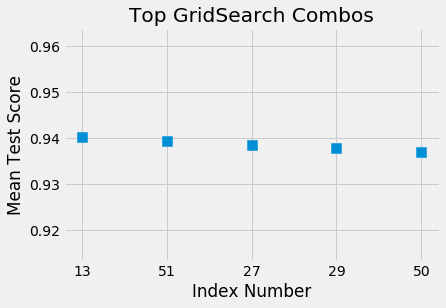

In [184]:
plt.scatter(x = x, y = y, marker='s', s=100)
plt.xticks(x, [13, 51, 27, 29, 50])
plt.title('Top GridSearch Combos')
plt.xlabel('Index Number')
plt.ylabel('Mean Test Score'); 

df_multi = selected__multi_params

d = dict(selector="th",
    props=[('text-align', 'center')])

df_multi.style.set_properties(**{'width':'40em', 'text-align':'center'})\
.set_table_styles([d])

Variations in the max_features, max_df, and min_df features lead to small changes in the mean test score but nothing significant.  I might try to expand the range of these parameters in my gridsearch in the future to see if I can improve my score.  I would be hesitant to lower the max_df parameter anywhere below 0.5.  Max_df ignores terms that have a document frequency strictly higher than the given threshold.  Lowering the max_df below 0.5 would ignore a singificant portion of the terms.

#### Pickle Multinomial Naives Bayes Model

In [185]:
with open('../Models/gs_multi.pkl', 'wb+') as f:
    pickle.dump(gs_multi, f)

#### Plot the Top 20 Words Post-Vectorization

In [186]:
sparse_data = gs_multi.best_estimator_.named_steps.tfidf.transform(X_train).toarray()
sparse_columns = gs_multi.best_estimator_.named_steps.tfidf.get_feature_names()

df_tfidf = pd.SparseDataFrame(data = sparse_data, 
                               columns = sparse_columns, 
                               default_fill_value=0)

df_tfidf.head()

,aampe,abc,abc cbs,abc fox,abc nbc,ability,able,able connect,able download,able play,...,youtube videos,youtubetv,youtubetv answer,yttv,yuzu,zero,zii,zii patcher,zip,zip code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
df_tfidf = df_tfidf.join(pd.DataFrame(y_test))
df_tfidf.head()

,aampe,abc,abc cbs,abc fox,abc nbc,ability,able,able connect,able download,able play,...,youtubetv,youtubetv answer,yttv,yuzu,zero,zii,zii patcher,zip,zip code,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
df_tfidf.rename(columns = {0: 'ytest'}, inplace=True)
df_tfidf = df_tfidf.groupby('ytest').mean().T
df_tfidf.columns = ['Piracy', 'Cordcutters']
df_tfidf = df_tfidf.iloc[:,::-1]

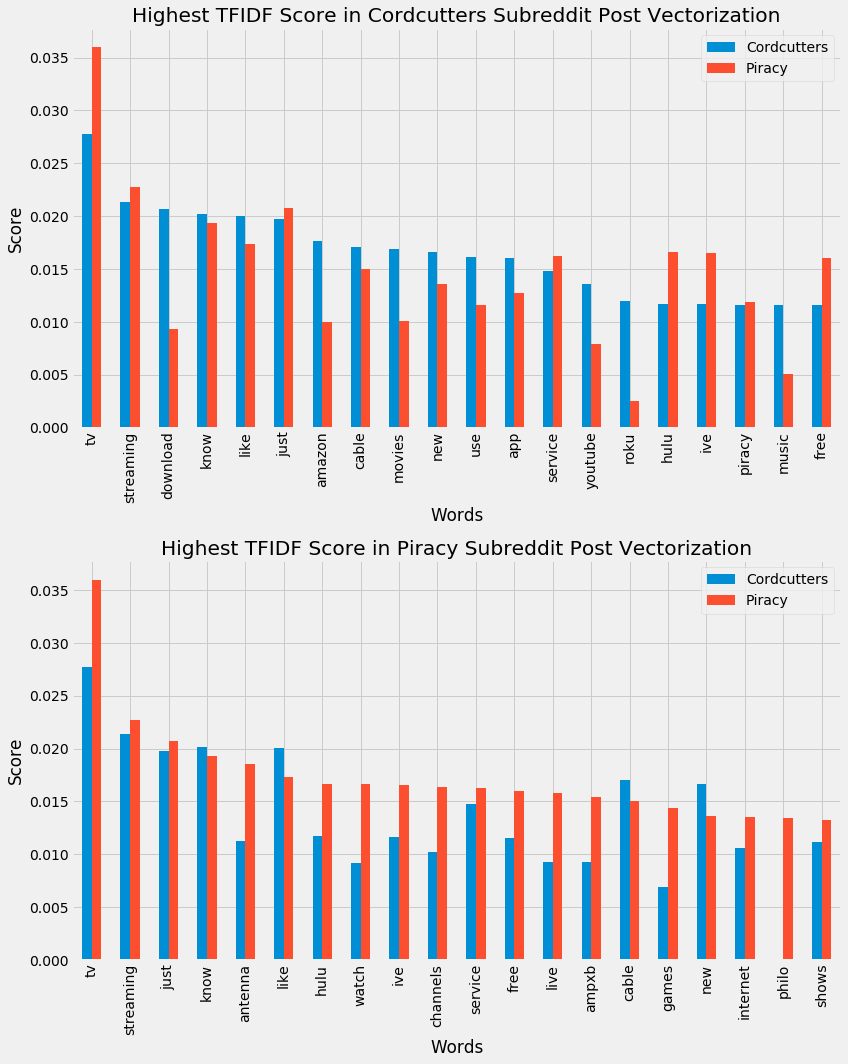

In [189]:
cc_tfidf_plot = df_tfidf.sort_values('Cordcutters', ascending=False)[:20]
piracy_tfidf_plot = df_tfidf.sort_values('Piracy', ascending=False)[:20]

figure, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12,15))
ax[0].set_xlabel('Words')
ax[1].set_xlabel('Words')
ax[0].set_ylabel('Score')
ax[1].set_ylabel('Score')

cc_tfidf_plot[:20].plot(ax = ax[0], title = 'Highest TFIDF Score in Cordcutters Subreddit Post Vectorization', kind='bar')
piracy_tfidf_plot[:20].plot(ax = ax[1], title = 'Highest TFIDF Score in Piracy Subreddit Post Vectorization', kind='bar')

figure.tight_layout();

#### Interpretation

These plots show the top 20 TFI-DF weighted words in each class.  This score represents a statistical measure which tells us how important a word is to a document in a collection or corpus.

#### Common Words Between Cordcutters and Piracy after both Count Vectorization and TF-IDF

I wanted to document which words were present in both of the top 20 weighted words list after Count Vectorization and after TF-IDF.  

In [190]:
cc_vec = ['tv', 'antenna', 'just', 'channels', 'streaming', 'internet', 'cable',
'live', 'like', 'service', 'watch', 'use', 'new', 'want', 'channel', 'sports',
'need', 'ive', 'cord', 'month'] 

cc_tiffy = list(df_tfidf.sort_values('Cordcutters', ascending=False)[:20].index)

print([i for i in cc_tiffy if i in cc_vec])

['tv', 'streaming', 'like', 'just', 'cable', 'new', 'use', 'service', 'ive']


In [191]:
piracy_vec = ['download', 'im', 'just', 'know', 'like','use', 'dont',
              'ampxb','ive','torrent','games','file', 'way','good','files',
              'piracy', 'version', 'need', 'windows', 'site']

piracy_tiffy = list(df_tfidf.sort_values('Piracy', ascending=False)[:20].index)

print([i for i in piracy_tiffy if i in piracy_vec])

['just', 'know', 'like', 'ive', 'ampxb', 'games']


#### Confusion Matrix for Multinomial Naives Bayes Model

In a confusion matrix each column represents a predicted class, while every row shows true classes. Therefore, every cell is one possible combination of predict and true classes.  In this confusion matrix true positives would be the number of posts that were predicted as 1s and are actually classified as 1s and true negatives would be the number of posts predicted as 0s and are actually classified as 0s.  We can see by the accuracy score (all correct/all) and the precision score (all positives/predicted positives) that this model is very effective in predicting which subreddit a post originates from.

In [192]:
y_pred = gs_multi.best_estimator_.predict(X_test)

In [193]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [194]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print('')
print(classification_report(y_test,y_pred))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[163  17]
 [  8 225]]

Accuracy: 0.9394673123486683

             precision    recall  f1-score   support

          0       0.95      0.91      0.93       180
          1       0.93      0.97      0.95       233

avg / total       0.94      0.94      0.94       413



#### ROC Score for Multinomial Naives Bayes Model

The Receiver Operating Curve (ROC) plots the true positive rate against the false positive rate.  The false positive rate in this case would be the posts predicted as 1s that are actually classified as 0s and the false negatives would be the posts classified as 0s that are actually classified as 1s.  The false positive rate is equal to one minus the true negative rate, thus the ROC is generated by plotting the sensivity (true positive rate) and specificity (true negative rate).  The ROC gives a sense about the tradeoff between sensitivity and specificity; a classifier that predicts at random will appear as the diagonal line. The closer the curve is to the upper left, the better overall accuracy of the model. 

This model represents the tradeoff in which the higher the true positives rate, the more false positive the classifier produces.  This is demonstrated in the ROC Curve in that it is very close to the upper left corner and its area under the curve (AUC) is 0.99, where a perfect classifier will have a ROC-AUC of 1.0.

In [195]:
fpr, tpr, threshold = roc_curve(y_test, gs_multi.predict_proba(X_test)[:, 1])

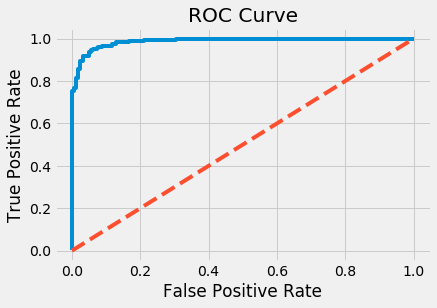

In [196]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [197]:
roc_auc_score(y_test, gs_multi.predict_proba(X_test)[:, 1])

0.9880782069623272

## TF-IDF Vectorizer with Logistic Regression Model

Logistic regression is a model used to estimate the probability that an instance belongs to a particular class.  If the estimate probability is greater than 50%, then the model predicts that the instance belongs to that class.  In the case of TF-IDF, the probability of success is the scaled frequency (whether a term is common or rare among all documents).  The C is the inverse of regularization strength where the smaller values specify stronger regularization. 
The L1 and L2 are used to specify the penalty (simlar to Lasso/Ridge) in linear regression.  "Class weight=balanced" works by replicating the smaller class until you have as many samples as in the larger one.  I chose to try this since there was about a 60/40 split in my classes.

In [198]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('logreg', LogisticRegression())])

In [199]:
params = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__max_df': [0.5,0.6,0.7],
    'tfidf__min_df': [2,3,4],
    'tfidf__ngram_range': [(1,2)],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C':  [1e3, 1e4, 1e5],
    'logreg__class_weight': [None, 'balanced']
}

In [200]:
gs_logreg = GridSearchCV(pipe, param_grid=params, cv=3)

In [201]:
gs_logreg.fit(X_train, y_train);

In [202]:
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(1.0, 0.9322033898305084)

In [203]:
gs_logreg.best_params_ 

{'logreg__C': 1000.0,
 'logreg__class_weight': 'balanced',
 'logreg__penalty': 'l2',
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 5000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

#### Plot the Top Five Gridsearch Parameter Combinations

In [204]:
selected__logreg_params = pd.DataFrame(gs_logreg.cv_results_).loc[:, ['params', 'mean_test_score']] \
.groupby('mean_test_score').count().sort_values('mean_test_score', ascending=False)
selected__logreg_params.head()

,params
mean_test_score,
0.942603,6
0.937753,6
0.936136,6
0.935327,1
0.934519,5


There are a number of combinations that yield the same score, so I will pick one from each.

In [208]:
selected__logreg_params = pd.DataFrame(gs_logreg.cv_results_) \
.loc[:,['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

In [210]:
selected__logreg_params = pd.DataFrame(gs_logreg.cv_results_) \
.loc[[87, 51, 210, 111, 36],['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
selected__logreg_params.head()

,params,mean_test_score
87,"{'logreg__C': 1000.0, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.942603
51,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.937753
210,"{'logreg__C': 10000.0, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.936136
111,"{'logreg__C': 10000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l1', 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.935327
36,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.6, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.934519


In [211]:
x = np.arange(selected__logreg_params.shape[0])

y = selected__logreg_params.mean_test_score.values

,params,mean_test_score
87,"{'logreg__C': 1000.0, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.942603
51,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.937753
210,"{'logreg__C': 10000.0, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.936136
111,"{'logreg__C': 10000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l1', 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.935327
36,"{'logreg__C': 1000.0, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'tfidf__max_df': 0.6, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.934519


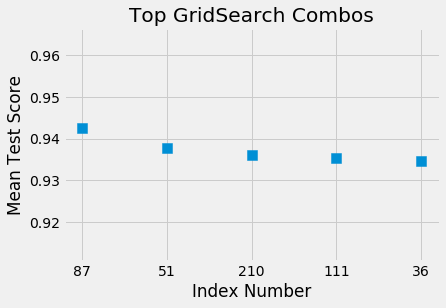

In [212]:
plt.scatter(x = x, y = y, marker='s', s=100)
plt.xticks(x, [87, 51, 210, 111, 36])
plt.title('Top GridSearch Combos')
plt.xlabel('Index Number')
plt.ylabel('Mean Test Score'); 

df_logreg = selected__logreg_params

d = dict(selector="th",
    props=[('text-align', 'center')])

df_logreg.style.set_properties(**{'width':'40em', 'text-align':'center'})\
.set_table_styles([d])

Again, there doesn't appear to be a big change in the mean test score when the different parameters are adjusted.  I might try expanding the upper range of max_df to see if it has any effect on the score.

#### Pickle Logistic Regression Model

In [213]:
with open('../Models/gs_logreg.pkl', 'wb+') as f:
    pickle.dump(gs_logreg, f)

#### Plot the Top 20 Coefficients Post-Vectorization

In [214]:
log_df = pd.DataFrame(gs_logreg.best_estimator_.steps[1][1].coef_,
                      columns = gs_logreg.best_estimator_.named_steps.tfidf.get_feature_names())
log_df.T.sort_values(0, ascending=False).head()

,0
antenna,16.804436
tv,14.811928
cable,12.357769
roku,11.588804
directv,11.358209


In [215]:
bar = log_df.T.sort_values(0, ascending=False).head(20).rename(columns={0:'Weight'})
bar = bar.reset_index().rename(columns={'index':'Word'})

In [216]:
bar

,Word,Weight
0,antenna,16.804436
1,tv,14.811928
2,cable,12.357769
3,roku,11.588804
4,directv,11.358209
5,cord,11.173628
6,service,10.991064
7,hulu,10.366121
8,fcc,9.518275
9,dvr,9.439499


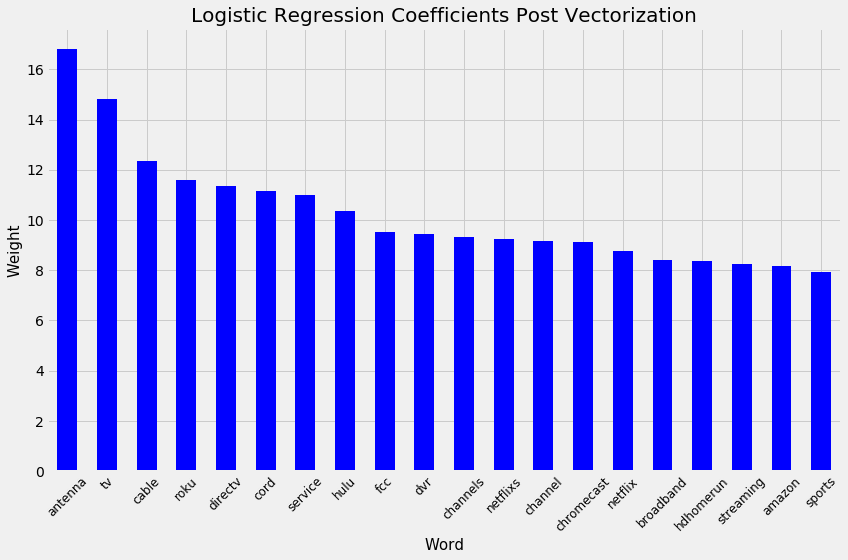

In [217]:
fig = bar.plot.bar('Word', 'Weight', figsize=(12, 8), legend=False, color='blue')
fig.set_xlabel('Word', size=15)
plt.xticks(size=12, rotation=45)
fig.set_ylabel('Weight', size=15)
fig.set_title('Logistic Regression Coefficients Post Vectorization', size=20);
plt.tight_layout()

#### Interpretation

This plot shows the top 20 most positive coefficients of the grid searched logistic regression model.  

#### Confusion Matrix for Logistic Regression Model

This model performs the best in terms of accuracy and precision.  These scores were most likely helped by the tuning of parameters that we conducted in the gridsearch.   

In [218]:
y_pred = gs_logreg.best_estimator_.predict(X_test)
y_proba = gs_logreg.predict_proba(X_test)

In [219]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [220]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print('')
print(classification_report(y_test,y_pred))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[168  12]
 [ 16 217]]

Accuracy: 0.9322033898305084

             precision    recall  f1-score   support

          0       0.91      0.93      0.92       180
          1       0.95      0.93      0.94       233

avg / total       0.93      0.93      0.93       413



#### Posts Where Y-Test and Y-Pred Don't Match

In logistic regression algorithms the predicted values are based off of probability estimates. That is, each observation is given an explicit probability of belonging in each class. I use use predict_proba to see the predicted probabilities for the posts.  I will take some posts that were recorded as false positives and false negatives under this model and I will try to find some patterns that exist.

In [221]:
model_analysis_df = pd.DataFrame(X_test, columns=['Raw Text'])
model_analysis_df.reset_index(drop=True, inplace=True)

In [222]:
y_proba_df = pd.DataFrame(y_proba)
y_proba_df.reset_index(drop=True, inplace=True)

In [223]:
model_analysis_df['actual'] = list(y_test)
model_analysis_df['predicted'] = y_pred
model_analysis_df['probability'] = y_proba_df[1]
model_analysis_df.head()

,Raw Text,actual,predicted,probability
0,directv now audio keeps skipping on my fire tv stick picture quality is good so its pretty annoying we have a netgear nighthawkhttps//expressgooglecom/product/mallwestlosangelesampdirectcheckoutamputmsourcegoogleshoppingamputmmediumproductadsamputmcampaigngsxamputmcontentcontrolmax router and im connected to our network via wifi but we have g fiber so wifi shouldnt be an issue right any ideas does the directv now app just suck on fire tv directv now audio quality on fire tv stick,1,1,0.999881
1,dont know if the files are still safe but when i go to igggames and i click literally anywhere not even an ad and i have ublock on it opens a tab to somewhere and recently it just tried to download something onto my computer automatically whenever id click a link the game it would do the same thing whats more is i tried turning off ublock to see how bad the ads are now and sure it enough it had that fake google popup for allowing notifications from the site with how bad the site is now i dont think its very worth it even if the files are safe edit i made a comment about all this on the contact me page and it says if any problem please call me right on top of the page it was waiting approval went over to check it and i guess it didnt get approved let alone addressed yup i definitely think igggames should be removed from the piracy megathread so igggames is cancer now,0,0,0.000016
2,as piracy is based around uploading copyrighted content how badly will article affect us now its passed,0,0,0.004361
3,was wondering if anyone know any pirated game forums where people play multiplayer and such for pirated games i am about to start divinity original sin definitive edition but was kinda wanting to play some lone wolf co op i cant just go to the normal forums or reddit lol if i am not allowed to post this on here i will delete thanks in advance pirated game forums,0,0,0.000366
4,i read on a post on here that there are keygens for current versions of malwarebytes antimalware is that true is it true that current versions of malwarebytes antimalware still have a current keygen that works,0,0,0.117214


In [224]:
false_pos = model_analysis_df.loc[(model_analysis_df['actual'] < model_analysis_df['predicted'])] \
.sort_values('probability', ascending=False)
false_pos.head()

,Raw Text,actual,predicted,probability
303,do all rippers of amazon/netflix video use screen capture or is there something to intercept the stream direct,0,1,0.988677
383,looking to watch the canelo vs triple g fight tomorrow night but ill be out of town so ill have to watch it on my phone any suggestions any good places to watch ppv boxing on iphone,0,1,0.952065
189,hey guys i have a shield tv and im wondering if theres a good app i can use to stream nfl games this year and other sports thanks best sports app for shield tv,0,1,0.942532
112,is there any way to be able to stream off of sites like gomovies from my phone to my chromecast without getting into trouble would i need a vpn on just my phone or also on my home wifi not sure what a good method would be how can i stay safe streaming via chromecast from phone,0,1,0.883672
246,how can i watch condensed games,0,1,0.799275


In [225]:
false_neg = model_analysis_df.loc[(model_analysis_df['actual'] > model_analysis_df['predicted'])] \
.sort_values('probability', ascending=False)
false_neg.head()

,Raw Text,actual,predicted,probability
326,why google fiber is highspeed internets most successful failure,1,0,0.453003
239,looking for suggestion for a setup that would best address two homes primary residence and summer home,1,0,0.420593
391,twentytwo states ask us appeals court to reinstate net neutrality rules,1,0,0.343050
226,tsunami of data could consume one fifth of global electricity by environment,1,0,0.338044
62,trump administration tells supreme court to wipe out decision upholding net neutrality,1,0,0.310185


In [226]:
for i, value in enumerate(list(false_pos.loc[:,'Raw Text'].head())):
    print(i+1, value)

1  do all rippers of amazon/netflix video use screen capture or is there something to intercept the stream direct
2 looking to watch the canelo vs triple g fight tomorrow night but ill be out of town so ill have to watch it on my phone any suggestions  any good places to watch ppv boxing on iphone
3 hey guys i have a shield tv and im wondering if theres a good app i can use to stream nfl games this year and other sports  thanks best sports app for shield tv
4 is there any way to be able to stream off of sites like gomovies from my phone to my chromecast without getting into trouble would i need a vpn on just my phone or also on my home wifi not sure what a good method would be  how can i stay safe streaming via chromecast from phone
5  how can i watch condensed games


#### Interpretation

In reading the top five posts that were recorded as false positives there are a number of words that would help explain why the algorithm misclassified these posts as cordcutters posts when they are in fact piracy posts.  Words like **netflix, stream, app, phone, sports, sites, games, websites, watch, tv shows, internet, just, use, want** are present in these posts and these were words that were featured in the post-vectorization top-20 lists and the statistically significant list that I calculated.  It is surprising that some of these posts were falsely predicted at such a high probability, but there were only four posts that were misclassified at a probability of over 80% so I think don't think it discounts the accuracy of this model.

In [274]:
for i, value in enumerate(list(false_neg.loc[:,'Raw Text'].head())):
    print(i+1, value)

1  why google fiber is highspeed internets most successful failure
2  looking for suggestion for a setup that would best address two homes primary residence and summer home
3  twentytwo states ask us appeals court to reinstate net neutrality rules
4  tsunami of data could consume one fifth of global electricity by   environment
5  trump administration tells supreme court to wipe out decision upholding net neutrality


#### Interpretation

These are the top five posts that were classified as piracy posts but were actually cordcutter posts.  These posts contain a number of words indicative of the top piracy features or statistically significant words, such as **google, internet, successful, net, data**.  Given that the top five false negative posts were predicted with a probabilty in the 30-45% range it is understandable that they would share a number of characteristics with piracy posts and could be misclassified as such.

#### ROC Score for Logistic Regression Model

This model has a ROC-AUC score that is just slightly lower than the Multinomial NB model's, but it is still very high. 

In [228]:
fpr, tpr, threshold = roc_curve(y_test, gs_logreg.predict_proba(X_test)[:, 1])

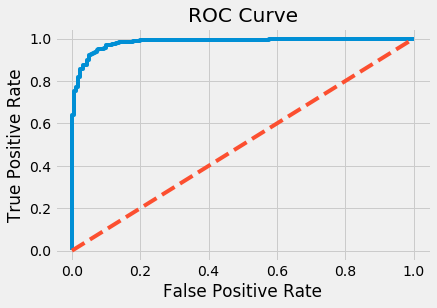

In [229]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [230]:
roc_auc_score(y_test, gs_logreg.predict_proba(X_test)[:, 1])

0.983381020505484

## TFIDF Vectorizer with Random Forest Classifier 

Random Forest builds an ensemble of decision trees.  Instead of searching for the most important feature while splitting a node, Random Forest searches for the best feature among a random subset of features and each node only considers a subset of features when determining the best split.

The n_estimators parameter sets the number of decision trees to include in the forest. When using random forest we are effectively training many decision tree models, so it is often useful to use all available cores by setting n_jobs=-1.  Leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data. The min_samples_split represents the minimum number of data points placed in a node before the node is split.  I tried the class_weight parameter again to address my slightly unbalanced classes.

In [232]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('rf', RandomForestClassifier())])

In [233]:
params = {
    'tfidf__max_features': [1000, 2000],
    'tfidf__max_df': [0.5, 0.6, 0.7],
    'tfidf__min_df': [2,3,4],
    'tfidf__ngram_range': [(1,2)],
    'rf__n_estimators': [50, 100],
    'rf__n_jobs': [1],
    'rf__min_samples_split': [2, 10, 20],
    'rf__min_samples_leaf': [10, 20],
    'rf__class_weight': [None, 'balanced']
}

In [234]:
gs_rf = GridSearchCV(pipe, param_grid=params, cv=3)

In [235]:
gs_rf.fit(X_train, y_train);

In [236]:
gs_rf.score(X_train, y_train), gs_rf.score(X_test, y_test)

(0.9070331447049312, 0.8861985472154964)

In [237]:
gs_rf.best_params_ 

{'rf__class_weight': None,
 'rf__min_samples_leaf': 10,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 50,
 'rf__n_jobs': 1,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 1000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

#### Plot the Top Five Gridsearch Parameter Combinations

In [249]:
selected__rf_params = pd.DataFrame(gs_rf.cv_results_).loc[:, ['params', 'mean_test_score']] \
.groupby('mean_test_score').count().sort_values('mean_test_score', ascending=False)
selected__rf_params.head()

,params
mean_test_score,
0.888440,1
0.883589,1
0.881973,1
0.881164,2
0.880356,2


There are a number of combinations that yield the same score, so I will pick one from each.

In [250]:
selected__rf_params = pd.DataFrame(gs_rf.cv_results_) \
.loc[:,['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)

In [251]:
selected__rf_params = pd.DataFrame(gs_rf.cv_results_) \
.loc[[0, 20, 103, 55, 36],['params', 'mean_test_score']].sort_values('mean_test_score', ascending=False)
selected__rf_params.head()

,params,mean_test_score
0,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.888440
20,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}",0.883589
103,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 20, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.7, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.881973
55,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.881164
36,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 50, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.880356


In [252]:
x = np.arange(selected__rf_params.shape[0])

y = selected__rf_params.mean_test_score.values

,params,mean_test_score
0,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 50, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.88844
20,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}",0.883589
103,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 20, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.7, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.881973
55,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 100, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2)}",0.881164
36,"{'rf__class_weight': None, 'rf__min_samples_leaf': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 50, 'rf__n_jobs': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 1000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}",0.880356


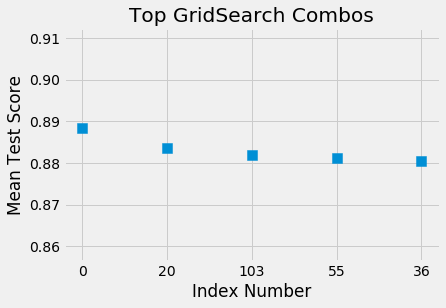

In [253]:
plt.scatter(x = x, y = y, marker='s', s=100)
plt.xticks(x, [0, 20, 103, 55, 36])
plt.title('Top GridSearch Combos')
plt.xlabel('Index Number')
plt.ylabel('Mean Test Score'); 

df_rf = selected__rf_params

d = dict(selector="th",
    props=[('text-align', 'center')])

df_rf.style.set_properties(**{'width':'40em', 'text-align':'center'})\
.set_table_styles([d])

There is a good amount of variation in the parameters of the top mean test scores and it is difficult to determine whether one parameter is affecting the score more than others. 

#### Pickle Random Forest Classifier

In [254]:
with open('../Models/gs_rt.pkl', 'wb+') as f:
    pickle.dump(gs_rf, f)

#### Confusion Matrix for Random Forest Classifier

In [255]:
y_pred = gs_rf.best_estimator_.predict(X_test)

In [256]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [257]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print('')
print(classification_report(y_test,y_pred))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[143  37]
 [ 10 223]]

Accuracy: 0.8861985472154964

             precision    recall  f1-score   support

          0       0.93      0.79      0.86       180
          1       0.86      0.96      0.90       233

avg / total       0.89      0.89      0.88       413



#### ROC Score for Random Forest Classifier

In [258]:
fpr, tpr, threshold = roc_curve(y_test, gs_rf.predict_proba(X_test)[:, 1])

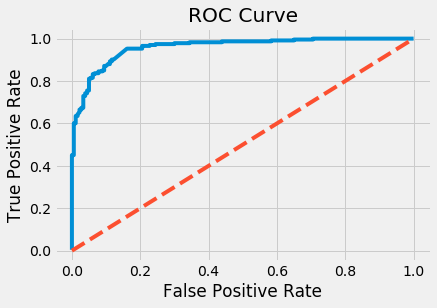

In [259]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [260]:
roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:, 1])

0.9593228421554602

## TFIDF Vectorizer Decision Tree Classifier

A decision tree divides the data set into smaller data sets until reaching a small enough set that contains data points that fall under one class. A partition is considered to be pure once all data of a specific class exists in it.  The min_samples_split represents the minimum number of samples required to split an internal node and the min_samples_leaf represents the minimum number of samples required to be at a leaf node.

In [261]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_word_list)),
    ('dt', DecisionTreeClassifier())])

In [262]:
params = {
    'tfidf__max_features': [1000, 2000],
    'tfidf__max_df': [0.5, 0.6, 0.7],
    'tfidf__min_df': [2,3,4],
    'tfidf__ngram_range': [(1,2)],
    'dt__min_samples_split': [10, 20],
    'dt__min_samples_leaf': [5, 10],
    'dt__class_weight': [None, 'balanced']
}

In [263]:
gs_dt = GridSearchCV(pipe, param_grid=params, cv=3)

In [264]:
gs_dt.fit(X_train, y_train);

In [265]:
gs_dt.score(X_train, y_train), gs_dt.score(X_test, y_test)

(0.9070331447049312, 0.8087167070217918)

In [266]:
gs_dt.best_params_ 

{'dt__class_weight': None,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 20,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': 2000,
 'tfidf__min_df': 3,
 'tfidf__ngram_range': (1, 2)}

#### Pickle Decision Tree Classifier

In [267]:
with open('../Models/gs_dt.pkl', 'wb+') as f:
    pickle.dump(gs_dt, f)

#### Confusion Matrix for Decision Tree Classifier

The accuracy and precision scores are worse under this model than the logistic and multinomial NB models.  Due to the decision tree's tendency to overfit, it tends to not produce great results if the training data is somewhat different thant the scoring data.  

In [268]:
y_pred = gs_dt.best_estimator_.predict(X_test)

In [269]:
matrix_def = [['tn','fp'], ['fn','tp']]
matrix = confusion_matrix(y_test, y_pred) 
tn, fp, fn, tp = matrix.ravel()

In [270]:
print('Matrix Definition')
print(np.array(matrix_def))
print('')
print('Confusion Matrix') 
print(matrix)
accuracy = (tp+tn)/(tn+fp+fn+tp)
precision = tp/(tp+fp)
print('')
print(f'Accuracy: {accuracy}')
print('')
print(classification_report(y_test,y_pred))

Matrix Definition
[['tn' 'fp']
 ['fn' 'tp']]

Confusion Matrix
[[139  41]
 [ 38 195]]

Accuracy: 0.8087167070217918

             precision    recall  f1-score   support

          0       0.79      0.77      0.78       180
          1       0.83      0.84      0.83       233

avg / total       0.81      0.81      0.81       413



#### ROC Score for Decision Tree Classifier

In [271]:
fpr, tpr, threshold = roc_curve(y_test, gs_dt.predict_proba(X_test)[:, 1])

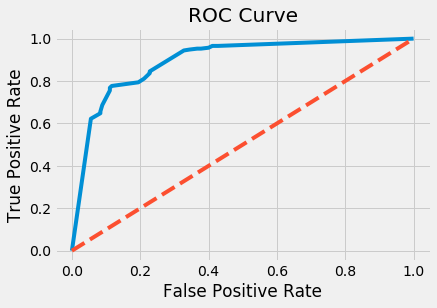

In [272]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [273]:
roc_auc_score(y_test, gs_dt.predict_proba(X_test)[:, 1])

0.8945398187887459

# <center>Scores Table</center>

<center>Model</center>                   |<center>Accuracy</center>   |<center>ROC AUC</center>
:--------------------------------------- |--------------|-------------|------------------------
Multinomial Naives Bayes</center>        |<center>0.939</center>      |<center>0.988</center>
Logistic Regression</center>             |<center>0.932</center>      |<center>0.983</center> 
Random Forest</center>                   |<center>0.886</center>      |<center>0.959</center>
Decision Tree</center>                   |<center>0.809</center>      |<center>0.895</center>